Using video_folder: /home/run/media/localdiskD/Ahmedabad University/6th SEM/ML/ML_2025_4_Cluster_555/dataset(Copy)/processed
Processing directory: 10
Found 101 normal CSV files
Found 58 abnormal CSV files
Processing directory: 11
Found 248 normal CSV files
Found 103 abnormal CSV files
Processing directory: 12
Found 206 normal CSV files
Found 70 abnormal CSV files
Loaded 697 trajectories after filtering.
Feature extraction complete. Sample data:
   track_id  label                                          file_path  \
0         1      0  /home/run/media/localdiskD/Ahmedabad Universit...   
1         2      0  /home/run/media/localdiskD/Ahmedabad Universit...   
2         3      0  /home/run/media/localdiskD/Ahmedabad Universit...   
3         4      0  /home/run/media/localdiskD/Ahmedabad Universit...   
4         5      0  /home/run/media/localdiskD/Ahmedabad Universit...   

   curvature_adherence  speed_accel_violations  path_efficiency  \
0             0.535105                0.38235

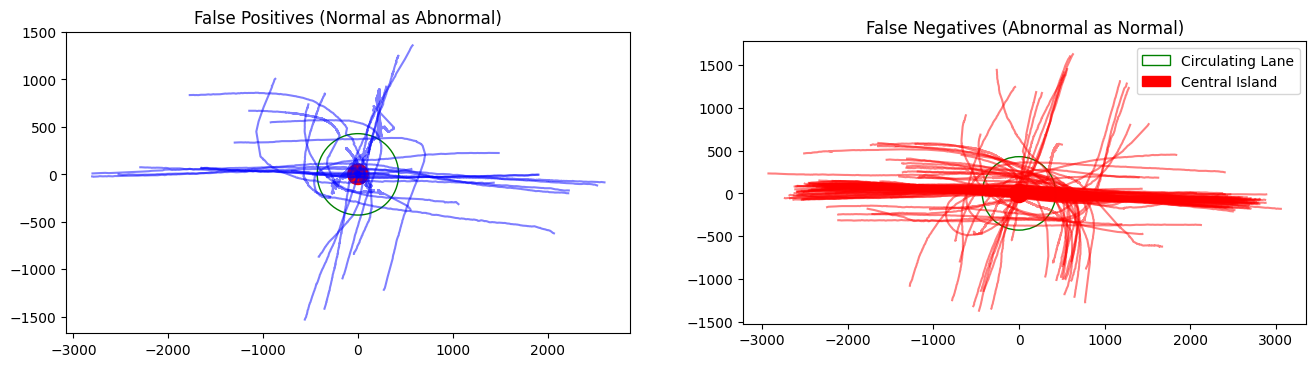

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

np.random.seed(42)

# Normalize coordinates using UAV geospatial data
def normalize_coordinates(df: pd.DataFrame, long: float, lat: float, alt: float, global_width: float = 1920, global_height: float = 1080) -> pd.DataFrame:
    alt_scale = alt / 100.0  # Adjust scale based on altitude (meters to pixel ratio)
    df['x_global'] = (df['left'] + df['w'] / 2) * alt_scale
    df['y_global'] = (df['top'] + df['h'] / 2) * alt_scale
    df['x_local'] = df['x_global'] - np.mean(df['x_global'])
    df['y_local'] = df['y_global'] - np.mean(df['y_global'])
    return df

# Convert DataFrame to points in local coordinates
def df_to_points(df: pd.DataFrame) -> List[Tuple[int, float, float]]:
    return [(int(row['frameNo']), row['x_local'], row['y_local']) for _, row in df.iterrows()]

# Check if trajectory intersects the roundabout
def is_roundabout_trajectory(points: List[Tuple[int, float, float]], center_x: float, center_y: float, radius: float) -> bool:
    distances = [np.sqrt((p[1] - center_x)**2 + (p[2] - center_y)**2) for p in points]
    return any(d < radius * 1.5 for d in distances)

# Derive roundabout geometry using turning trajectories
def derive_roundabout_geometry(normal_trajectories: List[pd.DataFrame]) -> Tuple[float, float, float]:
    turning_trajectories = []
    for traj_df in normal_trajectories:
        points = df_to_points(traj_df)  # Now safe because normalization is done earlier
        if len(points) < 2:
            continue
        angles = []
        center_x_temp, center_y_temp = np.mean([(p[1], p[2]) for p in points], axis=0)
        for p in points:
            dx = p[1] - center_x_temp
            dy = p[2] - center_y_temp
            angle = np.degrees(np.arctan2(dy, dx)) % 360
            angles.append(angle)
        angle_change = max(angles) - min(angles) if max(angles) > min(angles) else 360 + max(angles) - min(angles)
        if angle_change > 90:
            turning_trajectories.append(traj_df)
    
    if not turning_trajectories:
        print("Warning: No normal trajectories with significant turning found. Using all normal trajectories.")
        turning_trajectories = normal_trajectories
    
    all_points = [p for traj_df in turning_trajectories for p in df_to_points(traj_df)]
    if not all_points:
        return 0.0, 0.0, 100.0
    points_array = np.array([(p[1], p[2]) for p in all_points])
    center_x, center_y = np.mean(points_array, axis=0)
    db = DBSCAN(eps=50, min_samples=10).fit(points_array)
    labels = db.labels_
    core_points = points_array[labels != -1]
    if len(core_points) == 0:
        distances = np.sqrt((points_array[:, 0] - center_x)**2 + (points_array[:, 1] - center_y)**2)
        radius = np.percentile(distances, 75)
    else:
        distances = np.sqrt((core_points[:, 0] - center_x)**2 + (core_points[:, 1] - center_y)**2)
        radius = np.median(distances)
    return center_x, center_y, radius * 0.9

# Assign zone ID based on local coordinates
def assign_zone_id(x: float, y: float, center_x: float, center_y: float, radius: float) -> int:
    dx = x - center_x
    dy = y - center_y
    distance = np.sqrt(dx**2 + dy**2)
    angle = np.degrees(np.arctan2(dy, dx)) % 360
    if distance < radius * 0.25:
        return 0  # Central Island
    elif distance < radius:
        return 1  # Circulating Lane
    else:
        if 0 <= angle < 90 or 270 <= angle < 360:
            return 2
        elif 90 <= angle < 180:
            return 3
        elif 180 <= angle < 270:
            return 4
        else:
            return 5

# Get zone sequence
def get_zone_sequence(points: List[Tuple[int, float, float]], center_x: float, center_y: float, radius: float) -> List[int]:
    return [assign_zone_id(p[1], p[2], center_x, center_y, radius) for p in points]

# Calculate forbidden transitions
def calculate_forbidden_transitions(zone_seq: List[int]) -> int:
    valid_transitions = {(2, 1), (3, 1), (4, 1), (5, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 1)}
    forbidden_trans = 0
    for i in range(1, len(zone_seq)):
        if (zone_seq[i-1] in [2, 3, 4, 5] and zone_seq[i] in [2, 3, 4, 5] and 
            all(z != 1 for z in zone_seq[max(0, i-5):i+1]) and zone_seq[i-1] != zone_seq[i]):
            forbidden_trans += 1
        if zone_seq[i] == 0 and i > 0 and i < len(zone_seq) - 1:
            forbidden_trans += 1
    return forbidden_trans

# Calculate curvature adherence
def calculate_curvature_adherence(points: List[Tuple[int, float, float]], center_x: float, center_y: float, radius: float, zone_seq: List[int], fps: float = 1.0) -> float:
    expected_curvatures = []
    actual_curvatures = []
    entry_zone = next((z for z in zone_seq if z in [2, 3, 4, 5]), None)
    exit_zone = next((z for z in reversed(zone_seq) if z in [2, 3, 4, 5]), None)
    if entry_zone and exit_zone:
        zone_angles = {2: 0, 3: 90, 4: 180, 5: 270}
        expected_angle_change = abs(zone_angles[exit_zone] - zone_angles[entry_zone])
        expected_angle_change = min(expected_angle_change, 360 - expected_angle_change)
    else:
        expected_angle_change = 360
    expected_curvature_per_step = (expected_angle_change / len(points)) / (radius * 0.9) if radius > 0 else 0.0
    for i in range(1, len(points)):
        dx = points[i][1] - points[i-1][1]
        dy = points[i][2] - points[i-1][2]
        distance = np.sqrt(dx**2 + dy**2)
        time = (points[i][0] - points[i-1][0]) / fps
        velocity = distance / time if time > 0 else 0.0
        expected_curvatures.append(velocity * expected_curvature_per_step)
        x1, y1 = points[i-1][1] - center_x, points[i-1][2] - center_y
        x2, y2 = points[i][1] - center_x, points[i][2] - center_y
        angle1 = np.arctan2(y1, x1)
        angle2 = np.arctan2(y2, x2)
        angle_diff = abs((angle2 - angle1) % (2 * np.pi))
        if angle_diff > np.pi:
            angle_diff = 2 * np.pi - angle_diff
        actual_curvature = angle_diff / time if time > 0 else 0.0
        actual_curvatures.append(actual_curvature)
    if not expected_curvatures:
        return 0.0
    differences = np.abs(np.array(actual_curvatures) - np.array(expected_curvatures))
    mean_diff = np.mean(differences)
    adherence = 1 / (1 + mean_diff * 2)
    return max(0.0, min(1.0, adherence))

# Calculate circulation completion
def calculate_circulation_completion(points: List[Tuple[int, float, float]], center_x: float, center_y: float, zone_seq: List[int]) -> float:
    has_circulation = any(z == 1 for z in zone_seq)
    entry_exit_pattern = zone_seq[0] in [2, 3, 4, 5] and zone_seq[-1] in [2, 3, 4, 5] and has_circulation
    return 1.0 if entry_exit_pattern else 0.0

# Calculate speed and acceleration violations
def calculate_speed_and_acceleration_violations(points: List[Tuple[int, float, float]], normal_speed_min: float, normal_speed_max: float, normal_accel_max: float, fps: float = 1.0) -> float:
    speeds = []
    for i in range(1, len(points)):
        dx = points[i][1] - points[i-1][1]
        dy = points[i][2] - points[i-1][2]
        distance = np.sqrt(dx**2 + dy**2)
        time = (points[i][0] - points[i-1][0]) / fps
        speed = distance / time if time > 0 else 0.0
        speeds.append(speed)
    accels = []
    for i in range(1, len(speeds)):
        time = (points[i+1][0] - points[i][0]) / fps
        accel = (speeds[i] - speeds[i-1]) / time if time > 0 else 0.0
        accels.append(abs(accel))
    speed_violations = sum(1 for s in speeds if s < normal_speed_min or s > normal_speed_max)
    accel_violations = sum(1 for a in accels if a > normal_accel_max)
    total_violations = speed_violations + accel_violations
    return total_violations / len(points) if points else 0.0

# Calculate path efficiency
def calculate_path_efficiency(points: List[Tuple[int, float, float]], center_x: float, center_y: float, radius: float) -> float:
    total_distance = np.sum(np.sqrt(np.diff([p[1] for p in points])**2 + np.diff([p[2] for p in points])**2))
    start_end_distance = np.sqrt((points[-1][1] - points[0][1])**2 + (points[-1][2] - points[0][2])**2)
    efficiency = start_end_distance / total_distance if total_distance > 0 else 1.0
    zone_seq = get_zone_sequence(points, center_x, center_y, radius)
    if 0 in zone_seq[1:-1]:
        efficiency *= 0.5
    return efficiency

# In extract_features function, adjust central_island_violation
def calculate_central_island_violation(points: List[Tuple[int, float, float]], center_x: float, center_y: float, radius: float) -> float:
    zone_seq = get_zone_sequence(points, center_x, center_y, radius)
    central_island_points = sum(1 for zone in zone_seq if zone == 0)
    return central_island_points / len(points) if central_island_points > 0.1 * len(points) else 0.0  # Reduced threshold to 0.1


# Compute averages for thresholds
def compute_averages(trajectories: List[pd.DataFrame], labels: List[int], fps: float = 1.0) -> Tuple[float, float, float, float, float]:
    normal_speeds, normal_accels = [], []
    normal_trajectories = [traj for traj, label in zip(trajectories, labels) if label == 0]
    center_x, center_y, radius = derive_roundabout_geometry(normal_trajectories)
    for traj_df in normal_trajectories:
        points = df_to_points(traj_df)
        speeds = []
        for i in range(1, len(points)):
            dx = points[i][1] - points[i-1][1]
            dy = points[i][2] - points[i-1][2]
            distance = np.sqrt(dx**2 + dy**2)
            time = (points[i][0] - points[i-1][0]) / fps
            speed = distance / time if time > 0 else 0.0
            speeds.append(speed)
        normal_speeds.extend(speeds)
        for i in range(1, len(speeds)):
            time = (points[i+1][0] - points[i][0]) / fps
            accel = (speeds[i] - speeds[i-1]) / time if time > 0 else 0.0
            normal_accels.append(abs(accel))
    normal_speed_min = np.percentile(normal_speeds, 5) if normal_speeds else 0.0
    normal_speed_max = np.percentile(normal_speeds, 95) if normal_speeds else 10.0
    normal_accel_max = np.percentile(normal_accels, 95) if normal_accels else 1.0
    return normal_speed_min, normal_speed_max, normal_accel_max, 0.0, 0.0

# Extract features
def extract_features(trajectories: List[pd.DataFrame], labels: List[int], file_paths: List[str], fps: float = 1.0) -> pd.DataFrame:
    normal_trajectories = [traj for traj, label in zip(trajectories, labels) if label == 0]
    center_x, center_y, radius = derive_roundabout_geometry(normal_trajectories)
    normal_speed_min, normal_speed_max, normal_accel_max, _, _ = compute_averages(trajectories, labels, fps)
    results = []
    for idx, (traj_df, label, file_path) in enumerate(zip(trajectories, labels, file_paths)):
        # Trajectories are already normalized at this point
        points = df_to_points(traj_df)
        zone_seq = get_zone_sequence(points, center_x, center_y, radius)
        features = {
            'track_id': idx + 1,
            'label': label,
            'file_path': file_path,
            'curvature_adherence': calculate_curvature_adherence(points, center_x, center_y, radius, zone_seq, fps),
            'speed_accel_violations': calculate_speed_and_acceleration_violations(points, normal_speed_min, normal_speed_max, normal_accel_max, fps),
            'path_efficiency': calculate_path_efficiency(points, center_x, center_y, radius),
            'forbidden_transitions': calculate_forbidden_transitions(zone_seq),
            'circulation_completion': calculate_circulation_completion(points, center_x, center_y, zone_seq),
            'central_island_violation': calculate_central_island_violation(points, center_x, center_y, radius)
        }
        results.append(features)
    return pd.DataFrame(results)

# Clean DataFrame
def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df = df.replace([np.inf, -np.inf], np.nan).fillna(0)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    constant_cols = [col for col in numeric_cols if df[col].nunique() <= 1 or df[col].sum() == 0]
    df = df.drop(columns=constant_cols)
    return df

# Ensemble prediction
def ensemble_predict(db_labels: np.ndarray, rf_pred: np.ndarray, rf_prob: np.ndarray, threshold: float = 0.40) -> np.ndarray:
    rf_adjusted = (rf_prob[:, 1] >= threshold).astype(int)
    combined = np.vstack((db_labels, rf_adjusted))
    return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=combined)

# Plot individual trajectory
def plot_individual_trajectory(file_path: str, center_x: float, center_y: float, radius: float, title: str):
    df = pd.read_csv(file_path)
    long = np.mean(df['long'])
    lat = np.mean(df['lat'])
    alt = np.mean(df['alt'])
    df = normalize_coordinates(df, long, lat, alt)
    points = df_to_points(df)
    plt.figure(figsize=(8, 8))
    circle = plt.Circle((center_x, center_y), radius, color='g', fill=False, label='Circulating Lane')
    island = plt.Circle((center_x, center_y), radius * 0.25, color='r', fill=True, label='Central Island')
    plt.gca().add_patch(circle)
    plt.gca().add_patch(island)
    x, y = zip(*[(p[1], p[2]) for p in points])
    plt.plot(x, y, 'b-', label='Trajectory')
    plt.title(title)
    plt.legend()
    plt.axis('equal')
    plt.show()

# Plot misclassified trajectories
def plot_misclassified_trajectories(misclassified_paths: List[Tuple[str, int, int]], video_folder: str, center_x: float, center_y: float, radius: float):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    # Create separate circle and island patches for each axis
    circle1 = plt.Circle((center_x, center_y), radius, color='g', fill=False, label='Circulating Lane')
    island1 = plt.Circle((center_x, center_y), radius * 0.25, color='r', fill=True, label='Central Island')
    circle2 = plt.Circle((center_x, center_y), radius, color='g', fill=False, label='Circulating Lane')
    island2 = plt.Circle((center_x, center_y), radius * 0.25, color='r', fill=True, label='Central Island')
    ax1.add_patch(circle1)
    ax1.add_patch(island1)
    ax2.add_patch(circle2)
    ax2.add_patch(island2)
    ax1.set_aspect('equal')
    ax2.set_aspect('equal')
    false_positives = [(fp, tl, pl) for fp, tl, pl in misclassified_paths if tl == 0 and pl == 1]
    false_negatives = [(fp, tl, pl) for fp, tl, pl in misclassified_paths if tl == 1 and pl == 0]
    for file_path, _, _ in false_positives:
        df = pd.read_csv(file_path)
        long = np.mean(df['long'])
        lat = np.mean(df['lat'])
        alt = np.mean(df['alt'])
        df = normalize_coordinates(df, long, lat, alt)
        points = df_to_points(df)
        x, y = zip(*[(p[1], p[2]) for p in points])
        ax1.plot(x, y, 'b-', alpha=0.5)
    for file_path, _, _ in false_negatives:
        df = pd.read_csv(file_path)
        long = np.mean(df['long'])
        lat = np.mean(df['lat'])
        alt = np.mean(df['alt'])
        df = normalize_coordinates(df, long, lat, alt)
        points = df_to_points(df)
        x, y = zip(*[(p[1], p[2]) for p in points])
        ax2.plot(x, y, 'r-', alpha=0.5)
    ax1.set_title('False Positives (Normal as Abnormal)')
    ax2.set_title('False Negatives (Abnormal as Normal)')
    plt.legend()
    plt.show()

# Load trajectories with geospatial filtering
def load_trajectories(video_folder: str, min_points: int = 7) -> Tuple[List[pd.DataFrame], List[int], List[str]]:
    temp_trajectories, temp_labels, temp_file_paths = [], [], []
    for root, dirs, _ in os.walk(video_folder):
        if 'normal' and 'abnormal' in dirs:
            numbered_dir = os.path.basename(root)
            print(f"Processing directory: {numbered_dir}")
            for folder, label in [('normal', 0), ('abnormal', 1)]:
                path = os.path.join(root, folder)
                files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.csv')]
                print(f"Found {len(files)} {folder} CSV files")
                for file in files:
                    df = pd.read_csv(file)[['frameNo', 'left', 'top', 'w', 'h', 'long', 'lat', 'alt']].sort_values(by='frameNo')
                    if len(df) >= min_points:
                        # Normalize coordinates immediately after loading
                        long = np.mean(df['long'])
                        lat = np.mean(df['lat'])
                        alt = np.mean(df['alt'])
                        df_normalized = normalize_coordinates(df, long, lat, alt)
                        temp_trajectories.append(df_normalized)
                        temp_labels.append(label)
                        temp_file_paths.append(file)

    # Derive geometry using normalized trajectories
    normal_trajectories = [traj for traj, label in zip(temp_trajectories, temp_labels) if label == 0]
    center_x, center_y, radius = derive_roundabout_geometry(normal_trajectories)

    # Filter trajectories that intersect the roundabout
    trajectories, labels, file_paths = [], [], []
    for traj_df, label, file in zip(temp_trajectories, temp_labels, temp_file_paths):
        points = df_to_points(traj_df)  # Now safe because traj_df is already normalized
        if is_roundabout_trajectory(points, center_x, center_y, radius):
            trajectories.append(traj_df)
            labels.append(label)
            file_paths.append(file)
    return trajectories, labels, file_paths

if __name__ == "__main__":
    video_folder = "/home/run/media/localdiskD/Ahmedabad University/6th SEM/ML/ML_2025_4_Cluster_555/dataset(Copy)/processed"
    print(f"Using video_folder: {video_folder}")

    trajectories, labels, file_paths = load_trajectories(video_folder, min_points=7)
    print(f"Loaded {len(trajectories)} trajectories after filtering.")

    if len(trajectories) == 0:
        print("No trajectories loaded. Check directory structure.")
    else:
        fps = 1.0
        features_df = extract_features(trajectories, labels, file_paths, fps)
        print("Feature extraction complete. Sample data:")
        print(features_df.head())

        cleaned_df = clean_dataframe(features_df)
        numeric_features = [
            'curvature_adherence', 'speed_accel_violations',
            'path_efficiency', 'forbidden_transitions', 'circulation_completion',
            'central_island_violation'
        ]
        X = cleaned_df[numeric_features]
        y = np.array(cleaned_df['label'])
        file_paths_array = cleaned_df['file_path'].values
        print(f"Prepared {len(X)} samples with {len(numeric_features)} features.")

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        accuracies = []
        all_y_true = []
        all_y_pred = []
        all_file_paths = []
        misclassified_paths = []

        for fold, (train_idx, test_idx) in enumerate(kf.split(X_scaled)):
            X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            file_paths_test = file_paths_array[test_idx]

            db = DBSCAN(eps=0.4, min_samples=5).fit(X_train)
            db_labels_train = np.array([1 if label == -1 else 0 for label in db.labels_])
            db_labels_test = np.array([1 if label == -1 else 0 for label in DBSCAN(eps=0.4, min_samples=5).fit_predict(X_test)])

            rf_clf = RandomForestClassifier(
                random_state=42,
                n_estimators=400,
                max_depth=20,
                class_weight={0: 1, 1: 3}
            )
            rf_clf.fit(X_train, y_train)
            rf_pred = rf_clf.predict(X_test)
            rf_prob = rf_clf.predict_proba(X_test)

            y_pred_ensemble = ensemble_predict(db_labels_test, rf_pred, rf_prob, threshold=0.40)

            accuracies.append(accuracy_score(y_test, y_pred_ensemble))
            all_y_true.extend(y_test)
            all_y_pred.extend(y_pred_ensemble)
            all_file_paths.extend(file_paths_test)

            misclassified_indices = np.where(y_test != y_pred_ensemble)[0]
            for idx in misclassified_indices:
                true_label = y_test[idx]
                pred_label = y_pred_ensemble[idx]
                misclassified_paths.append((file_paths_test[idx], true_label, pred_label))

        print("\nEnsemble Classification Results (DBSCAN + RandomForest, 5-fold CV):")
        print(classification_report(all_y_true, all_y_pred))
        print(f"Average Accuracy: {np.mean(accuracies):.2f} (±{np.std(accuracies):.2f})")

        feature_importances = []
        for fold, (train_idx, test_idx) in enumerate(kf.split(X_scaled)):
            X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            rf_clf = RandomForestClassifier(
                random_state=42,
                n_estimators=400,
                max_depth=20,
                class_weight={0: 1, 1: 2}
            )
            rf_clf.fit(X_train, y_train)
            feature_importances.append(rf_clf.feature_importances_)
        avg_importances = np.mean(feature_importances, axis=0)
        rf_importances = pd.DataFrame({'Feature': numeric_features, 'Importance': avg_importances})
        print("\nAverage RandomForest Feature Importances:")
        print(rf_importances.sort_values(by='Importance', ascending=False))

        print("\nMisclassified Trajectories:")
        if misclassified_paths:
            for file_path, true_label, pred_label in misclassified_paths:
                label_str = "normal" if true_label == 0 else "abnormal"
                pred_str = "normal" if pred_label == 0 else "abnormal"
                print(f"File: {file_path}, True Label: {label_str}, Predicted Label: {pred_str}")
        else:
            print("No misclassified trajectories found.")

        normal_trajectories = [traj for traj, label in zip(trajectories, labels) if label == 0]
        center_x, center_y, radius = derive_roundabout_geometry(normal_trajectories)
        print(f"Derived Roundabout Geometry - Center: ({center_x}, {center_y}), Radius: {radius}")
        
        plot_misclassified_trajectories(misclassified_paths, video_folder, center_x, center_y, radius)

Using video_folder: /home/run/media/localdiskD/Ahmedabad University/6th SEM/ML/ML_2025_4_Cluster_555/dataset_interpolated/processed
Loaded 0 trajectories after filtering.
No trajectories loaded. Check directory structure.
Using video_folder: /home/run/media/localdiskD/Ahmedabad University/6th SEM/ML/ML_2025_4_Cluster_555/dataset(Copy)/processed
Processing directory: 10
Found 101 normal CSV files
Found 58 abnormal CSV files
Processing directory: 11
Found 248 normal CSV files
Found 103 abnormal CSV files
Processing directory: 12
Found 206 normal CSV files
Found 70 abnormal CSV files
Loaded 697 trajectories after filtering.
Feature extraction complete. Sample data:
   track_id  label                                          file_path  \
0         1      0  /home/run/media/localdiskD/Ahmedabad Universit...   
1         2      0  /home/run/media/localdiskD/Ahmedabad Universit...   
2         3      0  /home/run/media/localdiskD/Ahmedabad Universit...   
3         4      0  /home/run/media/l

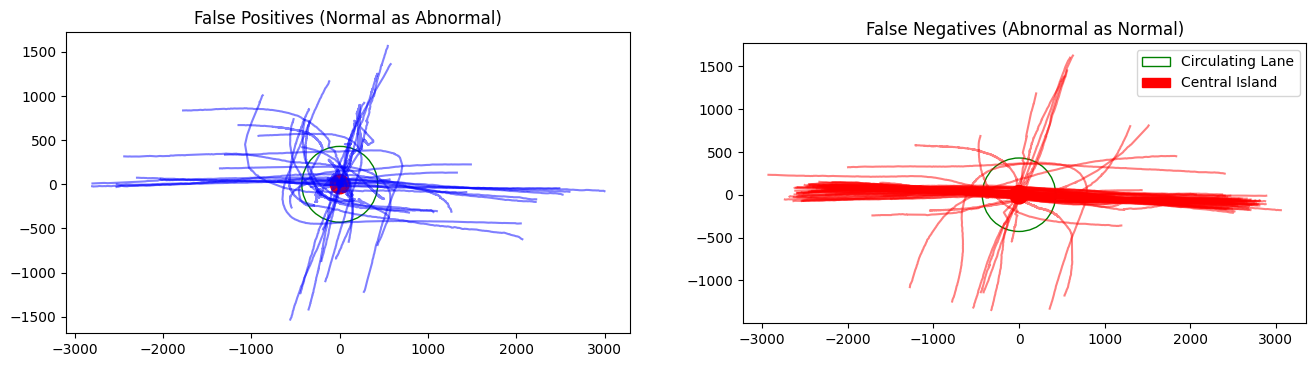


Detailed Analysis of Misclassifications:

False Positives (Normal as Abnormal) Summary:
       true_label  pred_label  curvature_adherence  speed_accel_violations  \
count        71.0        71.0            71.000000               71.000000   
mean          0.0         1.0             0.816466                1.220555   
std           0.0         0.0             0.195494                1.813571   
min           0.0         1.0             0.277202                0.000000   
25%           0.0         1.0             0.660362                0.129605   
50%           0.0         1.0             0.919842                0.554021   
75%           0.0         1.0             0.980434                1.664018   
max           0.0         1.0             0.992654               11.014686   

       path_efficiency  forbidden_transitions  circulation_completion  \
count        71.000000              71.000000               71.000000   
mean          0.288754             259.746479                0

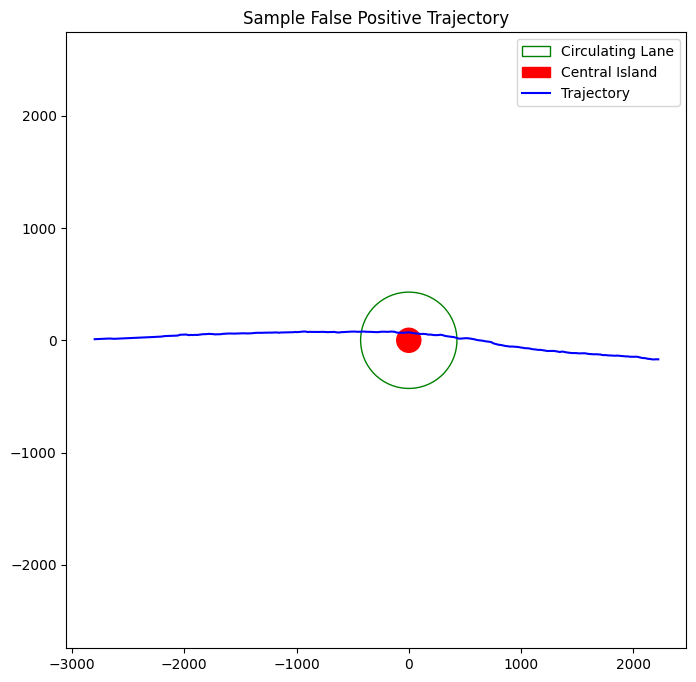

False Negative Sample: /home/run/media/localdiskD/Ahmedabad University/6th SEM/ML/ML_2025_4_Cluster_555/dataset(Copy)/processed/10/abnormal/332_340_350_388_389_402_410_467_481_515_542_.csv


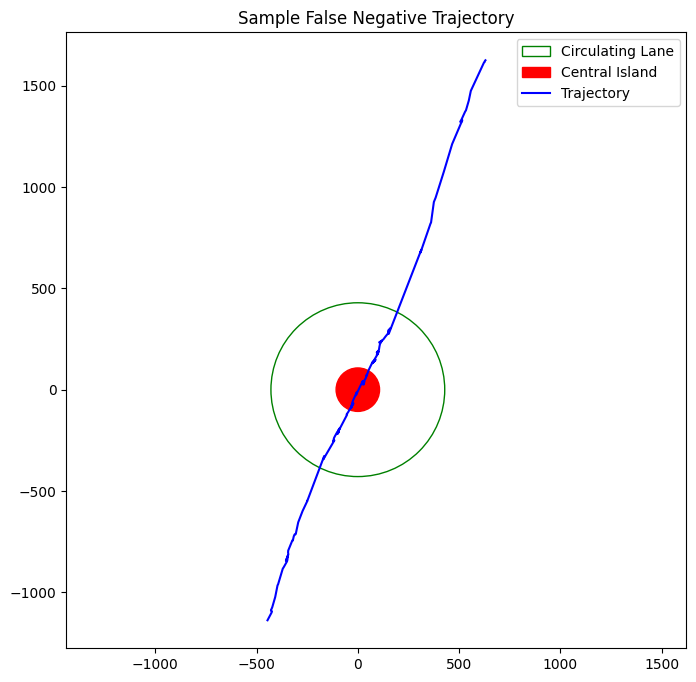


False Negatives (Abnormal as Normal):
- Mean central_island_violation: 0.16395704711934683
- Mean has_central_crossing: 0.9239130434782609
- Mean forbidden_transitions: 48.09782608695652
- Mean directional_variance: 13419.038692836673
Observation: Abnormal trajectories are being missed possibly due to insufficient sensitivity in central island violations or directional variance.

Plotting Sample Misclassified Trajectories:
False Positive Sample: /home/run/media/localdiskD/Ahmedabad University/6th SEM/ML/ML_2025_4_Cluster_555/dataset(Copy)/processed/10/normal/131_.csv


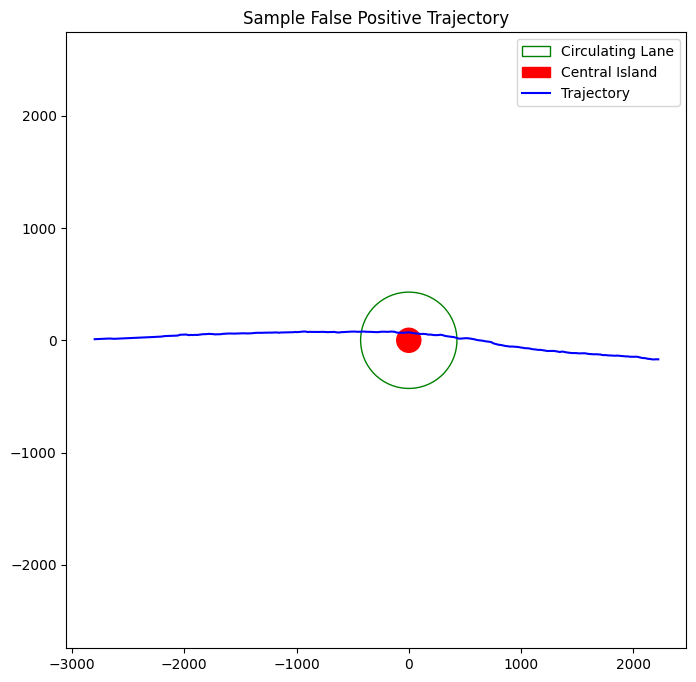

False Negative Sample: /home/run/media/localdiskD/Ahmedabad University/6th SEM/ML/ML_2025_4_Cluster_555/dataset(Copy)/processed/10/abnormal/332_340_350_388_389_402_410_467_481_515_542_.csv


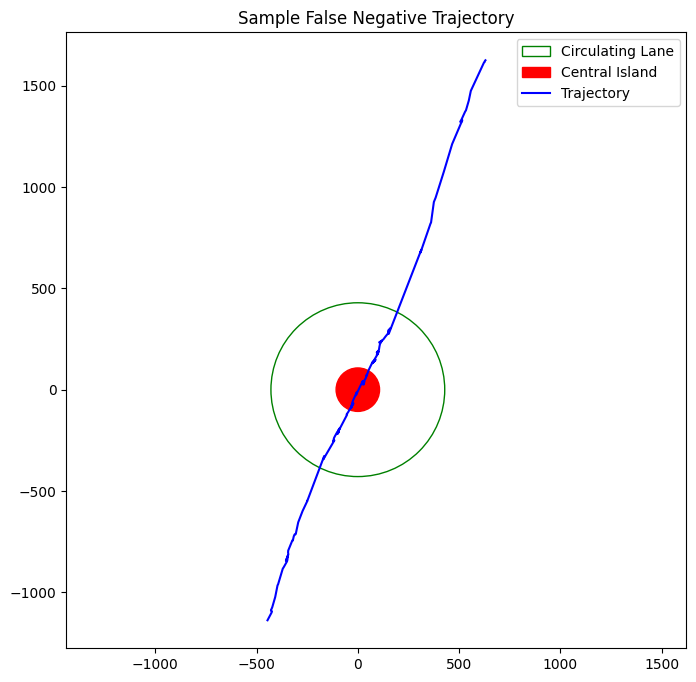

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

np.random.seed(42)

# Normalize coordinates using UAV geospatial data
def normalize_coordinates(df: pd.DataFrame, long: float, lat: float, alt: float, global_width: float = 1920, global_height: float = 1080) -> pd.DataFrame:
    alt_scale = alt / 100.0  # Adjust scale based on altitude (meters to pixel ratio)
    df['x_global'] = (df['left'] + df['w'] / 2) * alt_scale
    df['y_global'] = (df['top'] + df['h'] / 2) * alt_scale
    df['x_local'] = df['x_global'] - np.mean(df['x_global'])
    df['y_local'] = df['y_global'] - np.mean(df['y_global'])
    return df

# Convert DataFrame to points in local coordinates
def df_to_points(df: pd.DataFrame) -> List[Tuple[int, float, float]]:
    return [(int(row['frameNo']), row['x_local'], row['y_local']) for _, row in df.iterrows()]

# Check if trajectory intersects the roundabout
def is_roundabout_trajectory(points: List[Tuple[int, float, float]], center_x: float, center_y: float, radius: float) -> bool:
    distances = [np.sqrt((p[1] - center_x)**2 + (p[2] - center_y)**2) for p in points]
    return any(d < radius * 1.5 for d in distances)

# Derive roundabout geometry using turning trajectories
def derive_roundabout_geometry(normal_trajectories: List[pd.DataFrame]) -> Tuple[float, float, float]:
    turning_trajectories = []
    for traj_df in normal_trajectories:
        points = df_to_points(traj_df)
        if len(points) < 2:
            continue
        angles = []
        center_x_temp, center_y_temp = np.mean([(p[1], p[2]) for p in points], axis=0)
        for p in points:
            dx = p[1] - center_x_temp
            dy = p[2] - center_y_temp
            angle = np.degrees(np.arctan2(dy, dx)) % 360
            angles.append(angle)
        angle_change = max(angles) - min(angles) if max(angles) > min(angles) else 360 + max(angles) - min(angles)
        if angle_change > 90:
            turning_trajectories.append(traj_df)
    
    if not turning_trajectories:
        print("Warning: No normal trajectories with significant turning found. Using all normal trajectories.")
        turning_trajectories = normal_trajectories
    
    all_points = [p for traj_df in turning_trajectories for p in df_to_points(traj_df)]
    if not all_points:
        return 0.0, 0.0, 100.0
    points_array = np.array([(p[1], p[2]) for p in all_points])
    center_x, center_y = np.mean(points_array, axis=0)
    db = DBSCAN(eps=50, min_samples=10).fit(points_array)
    labels = db.labels_
    core_points = points_array[labels != -1]
    if len(core_points) == 0:
        distances = np.sqrt((points_array[:, 0] - center_x)**2 + (points_array[:, 1] - center_y)**2)
        radius = np.percentile(distances, 75)
    else:
        distances = np.sqrt((core_points[:, 0] - center_x)**2 + (core_points[:, 1] - center_y)**2)
        radius = np.median(distances)
    return center_x, center_y, radius * 0.9

# Assign zone ID based on local coordinates
def assign_zone_id(x: float, y: float, center_x: float, center_y: float, radius: float) -> int:
    dx = x - center_x
    dy = y - center_y
    distance = np.sqrt(dx**2 + dy**2)
    angle = np.degrees(np.arctan2(dy, dx)) % 360
    if distance < radius * 0.25:
        return 0  # Central Island
    elif distance < radius:
        return 1  # Circulating Lane
    else:
        if 0 <= angle < 90 or 270 <= angle < 360:
            return 2
        elif 90 <= angle < 180:
            return 3
        elif 180 <= angle < 270:
            return 4
        else:
            return 5

# Get zone sequence
def get_zone_sequence(points: List[Tuple[int, float, float]], center_x: float, center_y: float, radius: float) -> List[int]:
    return [assign_zone_id(p[1], p[2], center_x, center_y, radius) for p in points]

# Calculate forbidden transitions (Refined Logic)
def calculate_forbidden_transitions(zone_seq: List[int]) -> int:
    forbidden_trans = 0
    for i in range(1, len(zone_seq)):
        # Direct transitions between entry/exit zones without circulating
        if (zone_seq[i-1] in [2, 3, 4, 5] and zone_seq[i] in [2, 3, 4, 5] and 
            zone_seq[i-1] != zone_seq[i]):
            recent_zones = zone_seq[max(0, i-5):i]
            if not any(z == 1 for z in recent_zones):  # No circulation in recent steps
                forbidden_trans += 1
        # Penalize central island crossings unless at start/end (parking)
        if zone_seq[i] == 0 and i > 0 and i < len(zone_seq) - 1:
            forbidden_trans += 1
    return forbidden_trans

# Calculate curvature adherence (Refined Logic)
def calculate_curvature_adherence(points: List[Tuple[int, float, float]], center_x: float, center_y: float, radius: float, 
                                 zone_seq: List[int], fps: float = 1.0) -> float:
    expected_curvatures = []
    actual_curvatures = []
    # Identify entry and exit zones
    entry_zone = next((z for z in zone_seq if z in [2, 3, 4, 5]), None)
    exit_zone = next((z for z in reversed(zone_seq) if z in [2, 3, 4, 5]), None)
    if entry_zone and exit_zone:
        zone_angles = {2: 0, 3: 90, 4: 180, 5: 270}
        expected_angle_change = abs(zone_angles[exit_zone] - zone_angles[entry_zone])
        expected_angle_change = min(expected_angle_change, 360 - expected_angle_change)
    else:
        expected_angle_change = 360  # Assume full circulation if unclear
    expected_curvature_per_step = (expected_angle_change / len(points)) / (radius * 0.9) if radius > 0 else 0.0
    for i in range(1, len(points)):
        dx = points[i][1] - points[i-1][1]
        dy = points[i][2] - points[i-1][2]
        distance = np.sqrt(dx**2 + dy**2)
        time = (points[i][0] - points[i-1][0]) / fps
        velocity = distance / time if time > 0 else 0.0
        expected_curvatures.append(velocity * expected_curvature_per_step)
        x1, y1 = points[i-1][1] - center_x, points[i-1][2] - center_y
        x2, y2 = points[i][1] - center_x, points[i][2] - center_y
        angle1 = np.arctan2(y1, x1)
        angle2 = np.arctan2(y2, x2)
        angle_diff = abs((angle2 - angle1) % (2 * np.pi))
        if angle_diff > np.pi:
            angle_diff = 2 * np.pi - angle_diff
        actual_curvature = angle_diff / time if time > 0 else 0.0
        actual_curvatures.append(actual_curvature)
    if not expected_curvatures:
        return 0.0
    differences = np.abs(np.array(actual_curvatures) - np.array(expected_curvatures))
    mean_diff = np.mean(differences)
    adherence = 1 / (1 + mean_diff * 2)
    return max(0.0, min(1.0, adherence))

# Calculate circulation completion
def calculate_circulation_completion(points: List[Tuple[int, float, float]], center_x: float, center_y: float, 
                                    zone_seq: List[int]) -> float:
    has_circulation = any(z == 1 for z in zone_seq)
    entry_exit_pattern = zone_seq[0] in [2, 3, 4, 5] and zone_seq[-1] in [2, 3, 4, 5] and has_circulation
    return 1.0 if entry_exit_pattern else 0.0

# Calculate speed and acceleration violations (Refined Logic)
def calculate_speed_and_acceleration_violations(points: List[Tuple[int, float, float]], normal_speed_min: float, 
                                               normal_speed_max: float, normal_accel_max: float, fps: float = 1.0) -> float:
    speeds = []
    for i in range(1, len(points)):
        dx = points[i][1] - points[i-1][1]
        dy = points[i][2] - points[i-1][2]
        distance = np.sqrt(dx**2 + dy**2)
        time = (points[i][0] - points[i-1][0]) / fps
        speed = distance / time if time > 0 else 0.0
        speeds.append(speed)
    accels = []
    for i in range(1, len(speeds)):
        time = (points[i+1][0] - points[i][0]) / fps
        accel = (speeds[i] - speeds[i-1]) / time if time > 0 else 0.0
        accels.append(abs(accel))
    # Normalize violations by considering the magnitude of exceedance
    speed_violations = sum(max(0, s - normal_speed_max) / normal_speed_max if s > normal_speed_max else 
                          max(0, normal_speed_min - s) / normal_speed_min if s < normal_speed_min else 0 
                          for s in speeds)
    accel_violations = sum(max(0, a - normal_accel_max) / normal_accel_max for a in accels)
    total_violations = speed_violations + accel_violations
    return total_violations / len(points) if points else 0.0

# Calculate path efficiency
def calculate_path_efficiency(points: List[Tuple[int, float, float]], center_x: float, center_y: float, radius: float) -> float:
    total_distance = np.sum(np.sqrt(np.diff([p[1] for p in points])**2 + np.diff([p[2] for p in points])**2))
    start_end_distance = np.sqrt((points[-1][1] - points[0][1])**2 + (points[-1][2] - points[0][2])**2)
    efficiency = start_end_distance / total_distance if total_distance > 0 else 1.0
    zone_seq = get_zone_sequence(points, center_x, center_y, radius)
    if 0 in zone_seq[1:-1]:  # Penalize central island crossings
        efficiency *= 0.5
    return efficiency

# Calculate central island violation (Refined Logic)
def calculate_central_island_violation(points: List[Tuple[int, float, float]], center_x: float, center_y: float, 
                                      radius: float) -> Tuple[float, int]:
    zone_seq = get_zone_sequence(points, center_x, center_y, radius)
    central_island_points = sum(1 for zone in zone_seq if zone == 0)
    violation_ratio = central_island_points / len(points) if central_island_points > 0 else 0.0  # Removed threshold
    has_crossing = 1 if central_island_points > 0 else 0  # Binary flag for any crossing
    return violation_ratio, has_crossing

# New Feature: Maximum Acceleration Spike
def calculate_max_acceleration_spike(points: List[Tuple[int, float, float]], fps: float = 1.0) -> float:
    speeds = []
    for i in range(1, len(points)):
        dx = points[i][1] - points[i-1][1]
        dy = points[i][2] - points[i-1][2]
        distance = np.sqrt(dx**2 + dy**2)
        time = (points[i][0] - points[i-1][0]) / fps
        speed = distance / time if time > 0 else 0.0
        speeds.append(speed)
    accels = [abs(speeds[i] - speeds[i-1]) / (1/fps) for i in range(1, len(speeds))]
    return max(accels) if accels else 0.0

# New Feature: Directional Variance
def calculate_directional_variance(points: List[Tuple[int, float, float]], fps: float = 1.0) -> float:
    angles = []
    for i in range(1, len(points)):
        dx = points[i][1] - points[i-1][1]
        dy = points[i][2] - points[i-1][2]
        angle = np.degrees(np.arctan2(dy, dx)) % 360
        angles.append(angle)
    return np.var(angles) if angles else 0.0

# Compute averages for thresholds
def compute_averages(trajectories: List[pd.DataFrame], labels: List[int], fps: float = 1.0) -> Tuple[float, float, float, float, float]:
    normal_speeds, normal_accels = [], []
    normal_trajectories = [traj for traj, label in zip(trajectories, labels) if label == 0]
    center_x, center_y, radius = derive_roundabout_geometry(normal_trajectories)
    for traj_df in normal_trajectories:
        points = df_to_points(traj_df)
        speeds = []
        for i in range(1, len(points)):
            dx = points[i][1] - points[i-1][1]
            dy = points[i][2] - points[i-1][2]
            distance = np.sqrt(dx**2 + dy**2)
            time = (points[i][0] - points[i-1][0]) / fps
            speed = distance / time if time > 0 else 0.0
            speeds.append(speed)
        normal_speeds.extend(speeds)
        for i in range(1, len(speeds)):
            time = (points[i+1][0] - points[i][0]) / fps
            accel = (speeds[i] - speeds[i-1]) / time if time > 0 else 0.0
            normal_accels.append(abs(accel))
    normal_speed_min = np.percentile(normal_speeds, 5) if normal_speeds else 0.0
    normal_speed_max = np.percentile(normal_speeds, 95) if normal_speeds else 10.0
    normal_accel_max = np.percentile(normal_accels, 95) if normal_accels else 1.0
    return normal_speed_min, normal_speed_max, normal_accel_max, 0.0, 0.0

# Extract features (Updated with New Features)
def extract_features(trajectories: List[pd.DataFrame], labels: List[int], file_paths: List[str], fps: float = 1.0) -> pd.DataFrame:
    normal_trajectories = [traj for traj, label in zip(trajectories, labels) if label == 0]
    center_x, center_y, radius = derive_roundabout_geometry(normal_trajectories)
    normal_speed_min, normal_speed_max, normal_accel_max, _, _ = compute_averages(trajectories, labels, fps)
    results = []
    for idx, (traj_df, label, file_path) in enumerate(zip(trajectories, labels, file_paths)):
        points = df_to_points(traj_df)
        zone_seq = get_zone_sequence(points, center_x, center_y, radius)
        violation_ratio, has_crossing = calculate_central_island_violation(points, center_x, center_y, radius)
        features = {
            'track_id': idx + 1,
            'label': label,
            'file_path': file_path,
            'curvature_adherence': calculate_curvature_adherence(points, center_x, center_y, radius, zone_seq, fps),
            'speed_accel_violations': calculate_speed_and_acceleration_violations(points, normal_speed_min, normal_speed_max, normal_accel_max, fps),
            'path_efficiency': calculate_path_efficiency(points, center_x, center_y, radius),
            'forbidden_transitions': calculate_forbidden_transitions(zone_seq),
            'circulation_completion': calculate_circulation_completion(points, center_x, center_y, zone_seq),
            'central_island_violation': violation_ratio,
            'has_central_crossing': has_crossing,
            'max_acceleration_spike': calculate_max_acceleration_spike(points, fps),
            'directional_variance': calculate_directional_variance(points, fps)
        }
        results.append(features)
    return pd.DataFrame(results)

# Clean DataFrame
def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df = df.replace([np.inf, -np.inf], np.nan).fillna(0)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    constant_cols = [col for col in numeric_cols if df[col].nunique() <= 1 or df[col].sum() == 0]
    df = df.drop(columns=constant_cols)
    return df

# Ensemble prediction (Adjusted Threshold)
def ensemble_predict(db_labels: np.ndarray, rf_pred: np.ndarray, rf_prob: np.ndarray, threshold: float = 0.35) -> np.ndarray:
    rf_adjusted = (rf_prob[:, 1] >= threshold).astype(int)  # Lowered threshold to improve recall for abnormal
    combined = np.vstack((db_labels, rf_adjusted))
    return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=combined)

# Plot individual trajectory
def plot_individual_trajectory(file_path: str, center_x: float, center_y: float, radius: float, title: str):
    df = pd.read_csv(file_path)
    long = np.mean(df['long'])
    lat = np.mean(df['lat'])
    alt = np.mean(df['alt'])
    df = normalize_coordinates(df, long, lat, alt)
    points = df_to_points(df)
    plt.figure(figsize=(8, 8))
    circle = plt.Circle((center_x, center_y), radius, color='g', fill=False, label='Circulating Lane')
    island = plt.Circle((center_x, center_y), radius * 0.25, color='r', fill=True, label='Central Island')
    plt.gca().add_patch(circle)
    plt.gca().add_patch(island)
    x, y = zip(*[(p[1], p[2]) for p in points])
    plt.plot(x, y, 'b-', label='Trajectory')
    plt.title(title)
    plt.legend()
    plt.axis('equal')
    plt.show()

# Plot misclassified trajectories
def plot_misclassified_trajectories(misclassified_paths: List[Tuple[str, int, int]], video_folder: str, center_x: float, 
                                   center_y: float, radius: float):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    circle1 = plt.Circle((center_x, center_y), radius, color='g', fill=False, label='Circulating Lane')
    island1 = plt.Circle((center_x, center_y), radius * 0.25, color='r', fill=True, label='Central Island')
    circle2 = plt.Circle((center_x, center_y), radius, color='g', fill=False, label='Circulating Lane')
    island2 = plt.Circle((center_x, center_y), radius * 0.25, color='r', fill=True, label='Central Island')
    ax1.add_patch(circle1)
    ax1.add_patch(island1)
    ax2.add_patch(circle2)
    ax2.add_patch(island2)
    ax1.set_aspect('equal')
    ax2.set_aspect('equal')
    false_positives = [(fp, tl, pl) for fp, tl, pl in misclassified_paths if tl == 0 and pl == 1]
    false_negatives = [(fp, tl, pl) for fp, tl, pl in misclassified_paths if tl == 1 and pl == 0]
    for file_path, _, _ in false_positives:
        df = pd.read_csv(file_path)
        long = np.mean(df['long'])
        lat = np.mean(df['lat'])
        alt = np.mean(df['alt'])
        df = normalize_coordinates(df, long, lat, alt)
        points = df_to_points(df)
        x, y = zip(*[(p[1], p[2]) for p in points])
        ax1.plot(x, y, 'b-', alpha=0.5)
    for file_path, _, _ in false_negatives:
        df = pd.read_csv(file_path)
        long = np.mean(df['long'])
        lat = np.mean(df['lat'])
        alt = np.mean(df['alt'])
        df = normalize_coordinates(df, long, lat, alt)
        points = df_to_points(df)
        x, y = zip(*[(p[1], p[2]) for p in points])
        ax2.plot(x, y, 'r-', alpha=0.5)
    ax1.set_title('False Positives (Normal as Abnormal)')
    ax2.set_title('False Negatives (Abnormal as Normal)')
    plt.legend()
    plt.show()

# Analyze misclassified trajectories
def analyze_misclassified_trajectories(misclassified_paths: List[Tuple[str, int, int]], trajectories: List[pd.DataFrame], 
                                      file_paths: List[str], center_x: float, center_y: float, radius: float, fps: float = 1.0):
    misclassified_features = []
    for file_path, true_label, pred_label in misclassified_paths:
        idx = file_paths.index(file_path)
        traj_df = trajectories[idx]
        points = df_to_points(traj_df)
        zone_seq = get_zone_sequence(points, center_x, center_y, radius)
        
        # Calculate features
        curvature_adherence = calculate_curvature_adherence(points, center_x, center_y, radius, zone_seq, fps)
        speed_accel_violations = calculate_speed_and_acceleration_violations(points, 0.0, 10.0, 1.0, fps)  # Use placeholder thresholds
        path_efficiency = calculate_path_efficiency(points, center_x, center_y, radius)
        forbidden_transitions = calculate_forbidden_transitions(zone_seq)
        circulation_completion = calculate_circulation_completion(points, center_x, center_y, zone_seq)
        violation_ratio, has_crossing = calculate_central_island_violation(points, center_x, center_y, radius)
        max_acceleration_spike = calculate_max_acceleration_spike(points, fps)
        directional_variance = calculate_directional_variance(points, fps)
        
        # Raw data statistics
        x_local = [p[1] for p in points]
        y_local = [p[2] for p in points]
        mean_speed = np.mean([np.sqrt((p[1] - points[i-1][1])**2 + (p[2] - points[i-1][2])**2) / ((p[0] - points[i-1][0]) / fps) 
                             for i, p in enumerate(points[1:], 1) if i > 0 and (p[0] - points[i-1][0]) > 0]) if len(points) > 1 else 0.0
        max_x_deviation = max(x_local) - min(x_local) if x_local else 0.0
        max_y_deviation = max(y_local) - min(y_local) if y_local else 0.0
        central_crossings = sum(1 for x, y in zip(x_local, y_local) if np.sqrt((x - center_x)**2 + (y - center_y)**2) < radius * 0.25)
        
        features = {
            'file_path': file_path,
            'true_label': true_label,
            'pred_label': pred_label,
            'curvature_adherence': curvature_adherence,
            'speed_accel_violations': speed_accel_violations,
            'path_efficiency': path_efficiency,
            'forbidden_transitions': forbidden_transitions,
            'circulation_completion': circulation_completion,
            'central_island_violation': violation_ratio,
            'has_central_crossing': has_crossing,
            'max_acceleration_spike': max_acceleration_spike,
            'directional_variance': directional_variance,
            'num_points': len(points),
            'mean_speed': mean_speed,
            'max_x_deviation': max_x_deviation,
            'max_y_deviation': max_y_deviation,
            'central_crossings': central_crossings
        }
        misclassified_features.append(features)
    
    df_misclassified = pd.DataFrame(misclassified_features)
    print("\nMisclassified Trajectories Analysis:")
    print(df_misclassified)
    print("\nSummary Statistics for Misclassified Trajectories:")
    print(df_misclassified.describe())
    return df_misclassified

# Load trajectories with geospatial filtering
def load_trajectories(video_folder: str, min_points: int = 7) -> Tuple[List[pd.DataFrame], List[int], List[str]]:
    temp_trajectories, temp_labels, temp_file_paths = [], [], []
    for root, dirs, _ in os.walk(video_folder):
        if 'normal' and 'abnormal' in dirs:
            numbered_dir = os.path.basename(root)
            print(f"Processing directory: {numbered_dir}")
            for folder, label in [('normal', 0), ('abnormal', 1)]:
                path = os.path.join(root, folder)
                files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.csv')]
                print(f"Found {len(files)} {folder} CSV files")
                for file in files:
                    df = pd.read_csv(file)[['frameNo', 'left', 'top', 'w', 'h', 'long', 'lat', 'alt']].sort_values(by='frameNo')
                    if len(df) >= min_points:
                        long = np.mean(df['long'])
                        lat = np.mean(df['lat'])
                        alt = np.mean(df['alt'])
                        df_normalized = normalize_coordinates(df, long, lat, alt)
                        temp_trajectories.append(df_normalized)
                        temp_labels.append(label)
                        temp_file_paths.append(file)

    normal_trajectories = [traj for traj, label in zip(temp_trajectories, temp_labels) if label == 0]
    center_x, center_y, radius = derive_roundabout_geometry(normal_trajectories)

    trajectories, labels, file_paths = [], [], []
    for traj_df, label, file in zip(temp_trajectories, temp_labels, temp_file_paths):
        points = df_to_points(traj_df)
        if is_roundabout_trajectory(points, center_x, center_y, radius):
            trajectories.append(traj_df)
            labels.append(label)
            file_paths.append(file)
    return trajectories, labels, file_paths

if __name__ == "__main__":
    video_folder = "/home/run/media/localdiskD/Ahmedabad University/6th SEM/ML/ML_2025_4_Cluster_555/dataset(/processed"
    print(f"Using video_folder: {video_folder}")

    trajectories, labels, file_paths = load_trajectories(video_folder, min_points=7)
    print(f"Loaded {len(trajectories)} trajectories after filtering.")

    if len(trajectories) == 0:
        print("No trajectories loaded. Check directory structure.")
    else:
        fps = 1.0
        features_df = extract_features(trajectories, labels, file_paths, fps)
        print("Feature extraction complete. Sample data:")
        print(features_df.head())

        cleaned_df = clean_dataframe(features_df)
        numeric_features = [
            'curvature_adherence', 'speed_accel_violations', 'path_efficiency',
            'forbidden_transitions', 'circulation_completion', 'central_island_violation',
            'has_central_crossing', 'max_acceleration_spike', 'directional_variance'
        ]
        X = cleaned_df[numeric_features]
        y = np.array(cleaned_df['label'])
        file_paths_array = cleaned_df['file_path'].values
        print(f"Prepared {len(X)} samples with {len(numeric_features)} features.")

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        accuracies = []
        all_y_true = []
        all_y_pred = []
        all_file_paths = []
        misclassified_paths = []

        for fold, (train_idx, test_idx) in enumerate(kf.split(X_scaled)):
            X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            file_paths_test = file_paths_array[test_idx]

            db = DBSCAN(eps=0.35, min_samples=4).fit(X_train)  # Adjusted DBSCAN parameters
            db_labels_train = np.array([1 if label == -1 else 0 for label in db.labels_])
            db_labels_test = np.array([1 if label == -1 else 0 for label in DBSCAN(eps=0.35, min_samples=4).fit_predict(X_test)])

            rf_clf = RandomForestClassifier(
                random_state=42,
                n_estimators=400,
                max_depth=20,
                class_weight={0: 1, 1: 3}  # Increased weight for abnormal class
            )
            rf_clf.fit(X_train, y_train)
            rf_pred = rf_clf.predict(X_test)
            rf_prob = rf_clf.predict_proba(X_test)

            y_pred_ensemble = ensemble_predict(db_labels_test, rf_pred, rf_prob, threshold=0.35)

            accuracies.append(accuracy_score(y_test, y_pred_ensemble))
            all_y_true.extend(y_test)
            all_y_pred.extend(y_pred_ensemble)
            all_file_paths.extend(file_paths_test)

            misclassified_indices = np.where(y_test != y_pred_ensemble)[0]
            for idx in misclassified_indices:
                true_label = y_test[idx]
                pred_label = y_pred_ensemble[idx]
                misclassified_paths.append((file_paths_test[idx], true_label, pred_label))

        print("\nEnsemble Classification Results (DBSCAN + RandomForest, 5-fold CV):")
        print(classification_report(all_y_true, all_y_pred))
        print(f"Average Accuracy: {np.mean(accuracies):.2f} (±{np.std(accuracies):.2f})")

        feature_importances = []
        for fold, (train_idx, test_idx) in enumerate(kf.split(X_scaled)):
            X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            rf_clf = RandomForestClassifier(
                random_state=42,
                n_estimators=400,
                max_depth=20,
                class_weight={0: 1, 1: 3}
            )
            rf_clf.fit(X_train, y_train)
            feature_importances.append(rf_clf.feature_importances_)
        avg_importances = np.mean(feature_importances, axis=0)
        rf_importances = pd.DataFrame({'Feature': numeric_features, 'Importance': avg_importances})
        print("\nAverage RandomForest Feature Importances:")
        print(rf_importances.sort_values(by='Importance', ascending=False))

        print("\nMisclassified Trajectories:")
        if misclassified_paths:
            for file_path, true_label, pred_label in misclassified_paths:
                label_str = "normal" if true_label == 0 else "abnormal"
                pred_str = "normal" if pred_label == 0 else "abnormal"
                print(f"File: {file_path}, True Label: {label_str}, Predicted Label: {pred_str}")
        else:
            print("No misclassified trajectories found.")

        normal_trajectories = [traj for traj, label in zip(trajectories, labels) if label == 0]
        center_x, center_y, radius = derive_roundabout_geometry(normal_trajectories)
        print(f"Derived Roundabout Geometry - Center: ({center_x}, {center_y}), Radius: {radius}")

        # Analyze misclassified trajectories
        df_misclassified = analyze_misclassified_trajectories(misclassified_paths, trajectories, file_paths, center_x, center_y, radius, fps)

        # Plot misclassified trajectories
        plot_misclassified_trajectories(misclassified_paths, video_folder, center_x, center_y, radius)

        # Detailed Analysis of Misclassifications
        print("\nDetailed Analysis of Misclassifications:")
        
        # Separate false positives and false negatives
        false_positives = df_misclassified[df_misclassified['true_label'] == 0]
        false_negatives = df_misclassified[df_misclassified['true_label'] == 1]
        
        print("\nFalse Positives (Normal as Abnormal) Summary:")
        print(false_positives.describe())
        print("\nFalse Negatives (Abnormal as Normal) Summary:")
        print(false_negatives.describe())
        
        # Insights into Misclassifications
        print("\nInsights into Misclassifications:")
        
        # False Positives Analysis
        if not false_positives.empty:
            print("\nFalse Positives (Normal as Abnormal):")
            print("- Mean central_island_violation:", false_positives['central_island_violation'].mean())
            print("- Mean has_central_crossing:", false_positives['has_central_crossing'].mean())
            print("- Mean forbidden_transitions:", false_positives['forbidden_transitions'].mean())
            print("- Mean directional_variance:", false_positives['directional_variance'].mean())
            print("Observation: Normal trajectories are being misclassified as abnormal possibly due to high central island violations or forbidden transitions.")
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

np.random.seed(42)

# Normalize coordinates using UAV geospatial data
def normalize_coordinates(df: pd.DataFrame, long: float, lat: float, alt: float, global_width: float = 1920, global_height: float = 1080) -> pd.DataFrame:
    alt_scale = alt / 100.0  # Adjust scale based on altitude (meters to pixel ratio)
    df['x_global'] = (df['left'] + df['w'] / 2) * alt_scale
    df['y_global'] = (df['top'] + df['h'] / 2) * alt_scale
    df['x_local'] = df['x_global'] - np.mean(df['x_global'])
    df['y_local'] = df['y_global'] - np.mean(df['y_global'])
    return df

# Convert DataFrame to points in local coordinates
def df_to_points(df: pd.DataFrame) -> List[Tuple[int, float, float]]:
    return [(int(row['frameNo']), row['x_local'], row['y_local']) for _, row in df.iterrows()]

# Check if trajectory intersects the roundabout
def is_roundabout_trajectory(points: List[Tuple[int, float, float]], center_x: float, center_y: float, radius: float) -> bool:
    distances = [np.sqrt((p[1] - center_x)**2 + (p[2] - center_y)**2) for p in points]
    return any(d < radius * 1.5 for d in distances)

# Derive roundabout geometry using turning trajectories
def derive_roundabout_geometry(normal_trajectories: List[pd.DataFrame]) -> Tuple[float, float, float]:
    turning_trajectories = []
    for traj_df in normal_trajectories:
        points = df_to_points(traj_df)
        if len(points) < 2:
            continue
        angles = []
        center_x_temp, center_y_temp = np.mean([(p[1], p[2]) for p in points], axis=0)
        for p in points:
            dx = p[1] - center_x_temp
            dy = p[2] - center_y_temp
            angle = np.degrees(np.arctan2(dy, dx)) % 360
            angles.append(angle)
        angle_change = max(angles) - min(angles) if max(angles) > min(angles) else 360 + max(angles) - min(angles)
        if angle_change > 90:
            turning_trajectories.append(traj_df)
    
    if not turning_trajectories:
        print("Warning: No normal trajectories with significant turning found. Using all normal trajectories.")
        turning_trajectories = normal_trajectories
    
    all_points = [p for traj_df in turning_trajectories for p in df_to_points(traj_df)]
    if not all_points:
        return 0.0, 0.0, 100.0
    points_array = np.array([(p[1], p[2]) for p in all_points])
    center_x, center_y = np.mean(points_array, axis=0)
    db = DBSCAN(eps=50, min_samples=10).fit(points_array)
    labels = db.labels_
    core_points = points_array[labels != -1]
    if len(core_points) == 0:
        distances = np.sqrt((points_array[:, 0] - center_x)**2 + (points_array[:, 1] - center_y)**2)
        radius = np.percentile(distances, 75)
    else:
        distances = np.sqrt((core_points[:, 0] - center_x)**2 + (core_points[:, 1] - center_y)**2)
        radius = np.median(distances)
    return center_x, center_y, radius * 0.9

# Assign zone ID based on local coordinates
def assign_zone_id(x: float, y: float, center_x: float, center_y: float, radius: float) -> int:
    dx = x - center_x
    dy = y - center_y
    distance = np.sqrt(dx**2 + dy**2)
    angle = np.degrees(np.arctan2(dy, dx)) % 360
    if distance < radius * 0.25:
        return 0  # Central Island
    elif distance < radius:
        return 1  # Circulating Lane
    else:
        if 0 <= angle < 90 or 270 <= angle < 360:
            return 2
        elif 90 <= angle < 180:
            return 3
        elif 180 <= angle < 270:
            return 4
        else:
            return 5

# Get zone sequence
def get_zone_sequence(points: List[Tuple[int, float, float]], center_x: float, center_y: float, radius: float) -> List[int]:
    return [assign_zone_id(p[1], p[2], center_x, center_y, radius) for p in points]

# Calculate forbidden transitions (Refined Logic)
def calculate_forbidden_transitions(zone_seq: List[int]) -> int:
    forbidden_trans = 0
    for i in range(1, len(zone_seq)):
        # Direct transitions between entry/exit zones without circulating
        if (zone_seq[i-1] in [2, 3, 4, 5] and zone_seq[i] in [2, 3, 4, 5] and 
            zone_seq[i-1] != zone_seq[i]):
            recent_zones = zone_seq[max(0, i-5):i]
            if not any(z == 1 for z in recent_zones):  # No circulation in recent steps
                forbidden_trans += 1
        # Penalize central island crossings unless at start/end (parking)
        if zone_seq[i] == 0 and i > 0 and i < len(zone_seq) - 1:
            forbidden_trans += 1
    return forbidden_trans

# Calculate curvature adherence (Refined Logic)
def calculate_curvature_adherence(points: List[Tuple[int, float, float]], center_x: float, center_y: float, radius: float, 
                                 zone_seq: List[int], fps: float = 1.0) -> float:
    expected_curvatures = []
    actual_curvatures = []
    # Identify entry and exit zones
    entry_zone = next((z for z in zone_seq if z in [2, 3, 4, 5]), None)
    exit_zone = next((z for z in reversed(zone_seq) if z in [2, 3, 4, 5]), None)
    if entry_zone and exit_zone:
        zone_angles = {2: 0, 3: 90, 4: 180, 5: 270}
        expected_angle_change = abs(zone_angles[exit_zone] - zone_angles[entry_zone])
        expected_angle_change = min(expected_angle_change, 360 - expected_angle_change)
    else:
        expected_angle_change = 360  # Assume full circulation if unclear
    expected_curvature_per_step = (expected_angle_change / len(points)) / (radius * 0.9) if radius > 0 else 0.0
    for i in range(1, len(points)):
        dx = points[i][1] - points[i-1][1]
        dy = points[i][2] - points[i-1][2]
        distance = np.sqrt(dx**2 + dy**2)
        time = (points[i][0] - points[i-1][0]) / fps
        velocity = distance / time if time > 0 else 0.0
        expected_curvatures.append(velocity * expected_curvature_per_step)
        x1, y1 = points[i-1][1] - center_x, points[i-1][2] - center_y
        x2, y2 = points[i][1] - center_x, points[i][2] - center_y
        angle1 = np.arctan2(y1, x1)
        angle2 = np.arctan2(y2, x2)
        angle_diff = abs((angle2 - angle1) % (2 * np.pi))
        if angle_diff > np.pi:
            angle_diff = 2 * np.pi - angle_diff
        actual_curvature = angle_diff / time if time > 0 else 0.0
        actual_curvatures.append(actual_curvature)
    if not expected_curvatures:
        return 0.0
    differences = np.abs(np.array(actual_curvatures) - np.array(expected_curvatures))
    mean_diff = np.mean(differences)
    adherence = 1 / (1 + mean_diff * 2)
    return max(0.0, min(1.0, adherence))

# Calculate circulation completion
def calculate_circulation_completion(points: List[Tuple[int, float, float]], center_x: float, center_y: float, 
                                    zone_seq: List[int]) -> float:
    has_circulation = any(z == 1 for z in zone_seq)
    entry_exit_pattern = zone_seq[0] in [2, 3, 4, 5] and zone_seq[-1] in [2, 3, 4, 5] and has_circulation
    return 1.0 if entry_exit_pattern else 0.0

# Calculate speed and acceleration violations (Refined Logic)
def calculate_speed_and_acceleration_violations(points: List[Tuple[int, float, float]], normal_speed_min: float, 
                                               normal_speed_max: float, normal_accel_max: float, fps: float = 1.0) -> float:
    speeds = []
    for i in range(1, len(points)):
        dx = points[i][1] - points[i-1][1]
        dy = points[i][2] - points[i-1][2]
        distance = np.sqrt(dx**2 + dy**2)
        time = (points[i][0] - points[i-1][0]) / fps
        speed = distance / time if time > 0 else 0.0
        speeds.append(speed)
    accels = []
    for i in range(1, len(speeds)):
        time = (points[i+1][0] - points[i][0]) / fps
        accel = (speeds[i] - speeds[i-1]) / time if time > 0 else 0.0
        accels.append(abs(accel))
    # Normalize violations by considering the magnitude of exceedance
    speed_violations = sum(max(0, s - normal_speed_max) / normal_speed_max if s > normal_speed_max else 
                          max(0, normal_speed_min - s) / normal_speed_min if s < normal_speed_min else 0 
                          for s in speeds)
    accel_violations = sum(max(0, a - normal_accel_max) / normal_accel_max for a in accels)
    total_violations = speed_violations + accel_violations
    return total_violations / len(points) if points else 0.0

# Calculate path efficiency
def calculate_path_efficiency(points: List[Tuple[int, float, float]], center_x: float, center_y: float, radius: float) -> float:
    total_distance = np.sum(np.sqrt(np.diff([p[1] for p in points])**2 + np.diff([p[2] for p in points])**2))
    start_end_distance = np.sqrt((points[-1][1] - points[0][1])**2 + (points[-1][2] - points[0][2])**2)
    efficiency = start_end_distance / total_distance if total_distance > 0 else 1.0
    zone_seq = get_zone_sequence(points, center_x, center_y, radius)
    if 0 in zone_seq[1:-1]:  # Penalize central island crossings
        efficiency *= 0.5
    return efficiency

# Calculate central island violation (Refined Logic)
def calculate_central_island_violation(points: List[Tuple[int, float, float]], center_x: float, center_y: float, 
                                      radius: float) -> Tuple[float, int]:
    zone_seq = get_zone_sequence(points, center_x, center_y, radius)
    central_island_points = sum(1 for zone in zone_seq if zone == 0)
    violation_ratio = central_island_points / len(points) if central_island_points > 0 else 0.0  # Removed threshold
    has_crossing = 1 if central_island_points > 0 else 0  # Binary flag for any crossing
    return violation_ratio, has_crossing

# New Feature: Maximum Acceleration Spike
def calculate_max_acceleration_spike(points: List[Tuple[int, float, float]], fps: float = 1.0) -> float:
    speeds = []
    for i in range(1, len(points)):
        dx = points[i][1] - points[i-1][1]
        dy = points[i][2] - points[i-1][2]
        distance = np.sqrt(dx**2 + dy**2)
        time = (points[i][0] - points[i-1][0]) / fps
        speed = distance / time if time > 0 else 0.0
        speeds.append(speed)
    accels = [abs(speeds[i] - speeds[i-1]) / (1/fps) for i in range(1, len(speeds))]
    return max(accels) if accels else 0.0

# New Feature: Directional Variance
def calculate_directional_variance(points: List[Tuple[int, float, float]], fps: float = 1.0) -> float:
    angles = []
    for i in range(1, len(points)):
        dx = points[i][1] - points[i-1][1]
        dy = points[i][2] - points[i-1][2]
        angle = np.degrees(np.arctan2(dy, dx)) % 360
        angles.append(angle)
    return np.var(angles) if angles else 0.0

# Compute averages for thresholds
def compute_averages(trajectories: List[pd.DataFrame], labels: List[int], fps: float = 1.0) -> Tuple[float, float, float, float, float]:
    normal_speeds, normal_accels = [], []
    normal_trajectories = [traj for traj, label in zip(trajectories, labels) if label == 0]
    center_x, center_y, radius = derive_roundabout_geometry(normal_trajectories)
    for traj_df in normal_trajectories:
        points = df_to_points(traj_df)
        speeds = []
        for i in range(1, len(points)):
            dx = points[i][1] - points[i-1][1]
            dy = points[i][2] - points[i-1][2]
            distance = np.sqrt(dx**2 + dy**2)
            time = (points[i][0] - points[i-1][0]) / fps
            speed = distance / time if time > 0 else 0.0
            speeds.append(speed)
        normal_speeds.extend(speeds)
        for i in range(1, len(speeds)):
            time = (points[i+1][0] - points[i][0]) / fps
            accel = (speeds[i] - speeds[i-1]) / time if time > 0 else 0.0
            normal_accels.append(abs(accel))
    normal_speed_min = np.percentile(normal_speeds, 5) if normal_speeds else 0.0
    normal_speed_max = np.percentile(normal_speeds, 95) if normal_speeds else 10.0
    normal_accel_max = np.percentile(normal_accels, 95) if normal_accels else 1.0
    return normal_speed_min, normal_speed_max, normal_accel_max, 0.0, 0.0

# Extract features (Updated with New Features)
def extract_features(trajectories: List[pd.DataFrame], labels: List[int], file_paths: List[str], fps: float = 1.0) -> pd.DataFrame:
    normal_trajectories = [traj for traj, label in zip(trajectories, labels) if label == 0]
    center_x, center_y, radius = derive_roundabout_geometry(normal_trajectories)
    normal_speed_min, normal_speed_max, normal_accel_max, _, _ = compute_averages(trajectories, labels, fps)
    results = []
    for idx, (traj_df, label, file_path) in enumerate(zip(trajectories, labels, file_paths)):
        points = df_to_points(traj_df)
        zone_seq = get_zone_sequence(points, center_x, center_y, radius)
        violation_ratio, has_crossing = calculate_central_island_violation(points, center_x, center_y, radius)
        features = {
            'track_id': idx + 1,
            'label': label,
            'file_path': file_path,
            'curvature_adherence': calculate_curvature_adherence(points, center_x, center_y, radius, zone_seq, fps),
            'speed_accel_violations': calculate_speed_and_acceleration_violations(points, normal_speed_min, normal_speed_max, normal_accel_max, fps),
            'path_efficiency': calculate_path_efficiency(points, center_x, center_y, radius),
            'forbidden_transitions': calculate_forbidden_transitions(zone_seq),
            'circulation_completion': calculate_circulation_completion(points, center_x, center_y, zone_seq),
            'central_island_violation': violation_ratio,
            'has_central_crossing': has_crossing,
            'max_acceleration_spike': calculate_max_acceleration_spike(points, fps),
            'directional_variance': calculate_directional_variance(points, fps)
        }
        results.append(features)
    return pd.DataFrame(results)

# Clean DataFrame
def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df = df.replace([np.inf, -np.inf], np.nan).fillna(0)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    constant_cols = [col for col in numeric_cols if df[col].nunique() <= 1 or df[col].sum() == 0]
    df = df.drop(columns=constant_cols)
    return df

# Ensemble prediction (Adjusted Threshold)
def ensemble_predict(db_labels: np.ndarray, rf_pred: np.ndarray, rf_prob: np.ndarray, threshold: float = 0.35) -> np.ndarray:
    rf_adjusted = (rf_prob[:, 1] >= threshold).astype(int)  # Lowered threshold to improve recall for abnormal
    combined = np.vstack((db_labels, rf_adjusted))
    return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=combined)

# Plot individual trajectory
def plot_individual_trajectory(file_path: str, center_x: float, center_y: float, radius: float, title: str):
    df = pd.read_csv(file_path)
    long = np.mean(df['long'])
    lat = np.mean(df['lat'])
    alt = np.mean(df['alt'])
    df = normalize_coordinates(df, long, lat, alt)
    points = df_to_points(df)
    plt.figure(figsize=(8, 8))
    circle = plt.Circle((center_x, center_y), radius, color='g', fill=False, label='Circulating Lane')
    island = plt.Circle((center_x, center_y), radius * 0.25, color='r', fill=True, label='Central Island')
    plt.gca().add_patch(circle)
    plt.gca().add_patch(island)
    x, y = zip(*[(p[1], p[2]) for p in points])
    plt.plot(x, y, 'b-', label='Trajectory')
    plt.title(title)
    plt.legend()
    plt.axis('equal')
    plt.show()

# Plot misclassified trajectories
def plot_misclassified_trajectories(misclassified_paths: List[Tuple[str, int, int]], video_folder: str, center_x: float, 
                                   center_y: float, radius: float):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    circle1 = plt.Circle((center_x, center_y), radius, color='g', fill=False, label='Circulating Lane')
    island1 = plt.Circle((center_x, center_y), radius * 0.25, color='r', fill=True, label='Central Island')
    circle2 = plt.Circle((center_x, center_y), radius, color='g', fill=False, label='Circulating Lane')
    island2 = plt.Circle((center_x, center_y), radius * 0.25, color='r', fill=True, label='Central Island')
    ax1.add_patch(circle1)
    ax1.add_patch(island1)
    ax2.add_patch(circle2)
    ax2.add_patch(island2)
    ax1.set_aspect('equal')
    ax2.set_aspect('equal')
    false_positives = [(fp, tl, pl) for fp, tl, pl in misclassified_paths if tl == 0 and pl == 1]
    false_negatives = [(fp, tl, pl) for fp, tl, pl in misclassified_paths if tl == 1 and pl == 0]
    for file_path, _, _ in false_positives:
        df = pd.read_csv(file_path)
        long = np.mean(df['long'])
        lat = np.mean(df['lat'])
        alt = np.mean(df['alt'])
        df = normalize_coordinates(df, long, lat, alt)
        points = df_to_points(df)
        x, y = zip(*[(p[1], p[2]) for p in points])
        ax1.plot(x, y, 'b-', alpha=0.5)
    for file_path, _, _ in false_negatives:
        df = pd.read_csv(file_path)
        long = np.mean(df['long'])
        lat = np.mean(df['lat'])
        alt = np.mean(df['alt'])
        df = normalize_coordinates(df, long, lat, alt)
        points = df_to_points(df)
        x, y = zip(*[(p[1], p[2]) for p in points])
        ax2.plot(x, y, 'r-', alpha=0.5)
    ax1.set_title('False Positives (Normal as Abnormal)')
    ax2.set_title('False Negatives (Abnormal as Normal)')
    plt.legend()
    plt.show()

# Analyze misclassified trajectories
def analyze_misclassified_trajectories(misclassified_paths: List[Tuple[str, int, int]], trajectories: List[pd.DataFrame], 
                                      file_paths: List[str], center_x: float, center_y: float, radius: float, fps: float = 1.0):
    misclassified_features = []
    for file_path, true_label, pred_label in misclassified_paths:
        idx = file_paths.index(file_path)
        traj_df = trajectories[idx]
        points = df_to_points(traj_df)
        zone_seq = get_zone_sequence(points, center_x, center_y, radius)
        
        # Calculate features
        curvature_adherence = calculate_curvature_adherence(points, center_x, center_y, radius, zone_seq, fps)
        speed_accel_violations = calculate_speed_and_acceleration_violations(points, 0.0, 10.0, 1.0, fps)  # Use placeholder thresholds
        path_efficiency = calculate_path_efficiency(points, center_x, center_y, radius)
        forbidden_transitions = calculate_forbidden_transitions(zone_seq)
        circulation_completion = calculate_circulation_completion(points, center_x, center_y, zone_seq)
        violation_ratio, has_crossing = calculate_central_island_violation(points, center_x, center_y, radius)
        max_acceleration_spike = calculate_max_acceleration_spike(points, fps)
        directional_variance = calculate_directional_variance(points, fps)
        
        # Raw data statistics
        x_local = [p[1] for p in points]
        y_local = [p[2] for p in points]
        mean_speed = np.mean([np.sqrt((p[1] - points[i-1][1])**2 + (p[2] - points[i-1][2])**2) / ((p[0] - points[i-1][0]) / fps) 
                             for i, p in enumerate(points[1:], 1) if i > 0 and (p[0] - points[i-1][0]) > 0]) if len(points) > 1 else 0.0
        max_x_deviation = max(x_local) - min(x_local) if x_local else 0.0
        max_y_deviation = max(y_local) - min(y_local) if y_local else 0.0
        central_crossings = sum(1 for x, y in zip(x_local, y_local) if np.sqrt((x - center_x)**2 + (y - center_y)**2) < radius * 0.25)
        
        features = {
            'file_path': file_path,
            'true_label': true_label,
            'pred_label': pred_label,
            'curvature_adherence': curvature_adherence,
            'speed_accel_violations': speed_accel_violations,
            'path_efficiency': path_efficiency,
            'forbidden_transitions': forbidden_transitions,
            'circulation_completion': circulation_completion,
            'central_island_violation': violation_ratio,
            'has_central_crossing': has_crossing,
            'max_acceleration_spike': max_acceleration_spike,
            'directional_variance': directional_variance,
            'num_points': len(points),
            'mean_speed': mean_speed,
            'max_x_deviation': max_x_deviation,
            'max_y_deviation': max_y_deviation,
            'central_crossings': central_crossings
        }
        misclassified_features.append(features)
    
    df_misclassified = pd.DataFrame(misclassified_features)
    print("\nMisclassified Trajectories Analysis:")
    print(df_misclassified)
    print("\nSummary Statistics for Misclassified Trajectories:")
    print(df_misclassified.describe())
    return df_misclassified

# Load trajectories with geospatial filtering
def load_trajectories(video_folder: str, min_points: int = 7) -> Tuple[List[pd.DataFrame], List[int], List[str]]:
    temp_trajectories, temp_labels, temp_file_paths = [], [], []
    for root, dirs, _ in os.walk(video_folder):
        if 'normal' and 'abnormal' in dirs:
            numbered_dir = os.path.basename(root)
            print(f"Processing directory: {numbered_dir}")
            for folder, label in [('normal', 0), ('abnormal', 1)]:
                path = os.path.join(root, folder)
                files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.csv')]
                print(f"Found {len(files)} {folder} CSV files")
                for file in files:
                    df = pd.read_csv(file)[['frameNo', 'left', 'top', 'w', 'h', 'long', 'lat', 'alt']].sort_values(by='frameNo')
                    if len(df) >= min_points:
                        long = np.mean(df['long'])
                        lat = np.mean(df['lat'])
                        alt = np.mean(df['alt'])
                        df_normalized = normalize_coordinates(df, long, lat, alt)
                        temp_trajectories.append(df_normalized)
                        temp_labels.append(label)
                        temp_file_paths.append(file)

    normal_trajectories = [traj for traj, label in zip(temp_trajectories, temp_labels) if label == 0]
    center_x, center_y, radius = derive_roundabout_geometry(normal_trajectories)

    trajectories, labels, file_paths = [], [], []
    for traj_df, label, file in zip(temp_trajectories, temp_labels, temp_file_paths):
        points = df_to_points(traj_df)
        if is_roundabout_trajectory(points, center_x, center_y, radius):
            trajectories.append(traj_df)
            labels.append(label)
            file_paths.append(file)
    return trajectories, labels, file_paths

if __name__ == "__main__":
    video_folder = "/home/run/media/localdiskD/Ahmedabad University/6th SEM/ML/ML_2025_4_Cluster_555/dataset(Copy)/processed"
    print(f"Using video_folder: {video_folder}")

    trajectories, labels, file_paths = load_trajectories(video_folder, min_points=7)
    print(f"Loaded {len(trajectories)} trajectories after filtering.")

    if len(trajectories) == 0:
        print("No trajectories loaded. Check directory structure.")
    else:
        fps = 1.0
        features_df = extract_features(trajectories, labels, file_paths, fps)
        print("Feature extraction complete. Sample data:")
        print(features_df.head())

        cleaned_df = clean_dataframe(features_df)
        numeric_features = [
            'curvature_adherence', 'speed_accel_violations', 'path_efficiency',
            'forbidden_transitions', 'circulation_completion', 'central_island_violation',
            'has_central_crossing', 'max_acceleration_spike', 'directional_variance'
        ]
        X = cleaned_df[numeric_features]
        y = np.array(cleaned_df['label'])
        file_paths_array = cleaned_df['file_path'].values
        print(f"Prepared {len(X)} samples with {len(numeric_features)} features.")

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        accuracies = []
        all_y_true = []
        all_y_pred = []
        all_file_paths = []
        misclassified_paths = []

        for fold, (train_idx, test_idx) in enumerate(kf.split(X_scaled)):
            X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            file_paths_test = file_paths_array[test_idx]

            db = DBSCAN(eps=0.35, min_samples=4).fit(X_train)  # Adjusted DBSCAN parameters
            db_labels_train = np.array([1 if label == -1 else 0 for label in db.labels_])
            db_labels_test = np.array([1 if label == -1 else 0 for label in DBSCAN(eps=0.35, min_samples=4).fit_predict(X_test)])

            rf_clf = RandomForestClassifier(
                random_state=42,
                n_estimators=400,
                max_depth=20,
                class_weight={0: 1, 1: 3}  # Increased weight for abnormal class
            )
            rf_clf.fit(X_train, y_train)
            rf_pred = rf_clf.predict(X_test)
            rf_prob = rf_clf.predict_proba(X_test)

            y_pred_ensemble = ensemble_predict(db_labels_test, rf_pred, rf_prob, threshold=0.35)

            accuracies.append(accuracy_score(y_test, y_pred_ensemble))
            all_y_true.extend(y_test)
            all_y_pred.extend(y_pred_ensemble)
            all_file_paths.extend(file_paths_test)

            misclassified_indices = np.where(y_test != y_pred_ensemble)[0]
            for idx in misclassified_indices:
                true_label = y_test[idx]
                pred_label = y_pred_ensemble[idx]
                misclassified_paths.append((file_paths_test[idx], true_label, pred_label))

        print("\nEnsemble Classification Results (DBSCAN + RandomForest, 5-fold CV):")
        print(classification_report(all_y_true, all_y_pred))
        print(f"Average Accuracy: {np.mean(accuracies):.2f} (±{np.std(accuracies):.2f})")

        feature_importances = []
        for fold, (train_idx, test_idx) in enumerate(kf.split(X_scaled)):
            X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            rf_clf = RandomForestClassifier(
                random_state=42,
                n_estimators=400,
                max_depth=20,
                class_weight={0: 1, 1: 3}
            )
            rf_clf.fit(X_train, y_train)
            feature_importances.append(rf_clf.feature_importances_)
        avg_importances = np.mean(feature_importances, axis=0)
        rf_importances = pd.DataFrame({'Feature': numeric_features, 'Importance': avg_importances})
        print("\nAverage RandomForest Feature Importances:")
        print(rf_importances.sort_values(by='Importance', ascending=False))

        print("\nMisclassified Trajectories:")
        if misclassified_paths:
            for file_path, true_label, pred_label in misclassified_paths:
                label_str = "normal" if true_label == 0 else "abnormal"
                pred_str = "normal" if pred_label == 0 else "abnormal"
                print(f"File: {file_path}, True Label: {label_str}, Predicted Label: {pred_str}")
        else:
            print("No misclassified trajectories found.")

        normal_trajectories = [traj for traj, label in zip(trajectories, labels) if label == 0]
        center_x, center_y, radius = derive_roundabout_geometry(normal_trajectories)
        print(f"Derived Roundabout Geometry - Center: ({center_x}, {center_y}), Radius: {radius}")

        # Analyze misclassified trajectories
        df_misclassified = analyze_misclassified_trajectories(misclassified_paths, trajectories, file_paths, center_x, center_y, radius, fps)

        # Plot misclassified trajectories
        plot_misclassified_trajectories(misclassified_paths, video_folder, center_x, center_y, radius)

        # Detailed Analysis of Misclassifications
        print("\nDetailed Analysis of Misclassifications:")
        
        # Separate false positives and false negatives
        false_positives = df_misclassified[df_misclassified['true_label'] == 0]
        false_negatives = df_misclassified[df_misclassified['true_label'] == 1]
        
        print("\nFalse Positives (Normal as Abnormal) Summary:")
        print(false_positives.describe())
        print("\nFalse Negatives (Abnormal as Normal) Summary:")
        print(false_negatives.describe())
        
        # Insights into Misclassifications
        print("\nInsights into Misclassifications:")
        
        # False Positives Analysis
        if not false_positives.empty:
            print("\nFalse Positives (Normal as Abnormal):")
            print("- Mean central_island_violation:", false_positives['central_island_violation'].mean())
            print("- Mean has_central_crossing:", false_positives['has_central_crossing'].mean())
            print("- Mean forbidden_transitions:", false_positives['forbidden_transitions'].mean())
            print("- Mean directional_variance:", false_positives['directional_variance'].mean())
            print("Observation: Normal trajectories are being misclassified as abnormal possibly due to high central island violations or forbidden transitions.")
        
        # False Negatives Analysis
        if not false_negatives.empty:
            print("\nFalse Negatives (Abnormal as Normal):")
            print("- Mean central_island_violation:", false_negatives['central_island_violation'].mean())
            print("- Mean has_central_crossing:", false_negatives['has_central_crossing'].mean())
            print("- Mean forbidden_transitions:", false_negatives['forbidden_transitions'].mean())
            print("- Mean directional_variance:", false_negatives['directional_variance'].mean())
            print("Observation: Abnormal trajectories are being missed possibly due to insufficient sensitivity in central island violations or directional variance.")

        # Plot a few individual trajectories for inspection
        print("\nPlotting Sample Misclassified Trajectories:")
        if len(false_positives) > 0:
            sample_fp = false_positives.iloc[0]['file_path']
            print(f"False Positive Sample: {sample_fp}")
            plot_individual_trajectory(sample_fp, center_x, center_y, radius, "Sample False Positive Trajectory")
        if len(false_negatives) > 0:
            sample_fn = false_negatives.iloc[0]['file_path']
            print(f"False Negative Sample: {sample_fn}")
            plot_individual_trajectory(sample_fn, center_x, center_y, radius, "Sample False Negative Trajectory")
        # False Negatives Analysis
        if not false_negatives.empty:
            print("\nFalse Negatives (Abnormal as Normal):")
            print("- Mean central_island_violation:", false_negatives['central_island_violation'].mean())
            print("- Mean has_central_crossing:", false_negatives['has_central_crossing'].mean())
            print("- Mean forbidden_transitions:", false_negatives['forbidden_transitions'].mean())
            print("- Mean directional_variance:", false_negatives['directional_variance'].mean())
            print("Observation: Abnormal trajectories are being missed possibly due to insufficient sensitivity in central island violations or directional variance.")

        # Plot a few individual trajectories for inspection
        print("\nPlotting Sample Misclassified Trajectories:")
        if len(false_positives) > 0:
            sample_fp = false_positives.iloc[0]['file_path']
            print(f"False Positive Sample: {sample_fp}")
            plot_individual_trajectory(sample_fp, center_x, center_y, radius, "Sample False Positive Trajectory")
        if len(false_negatives) > 0:
            sample_fn = false_negatives.iloc[0]['file_path']
            print(f"False Negative Sample: {sample_fn}")
            plot_individual_trajectory(sample_fn, center_x, center_y, radius, "Sample False Negative Trajectory")